# Time Domain data analysis

# Data loading

(100, 3)


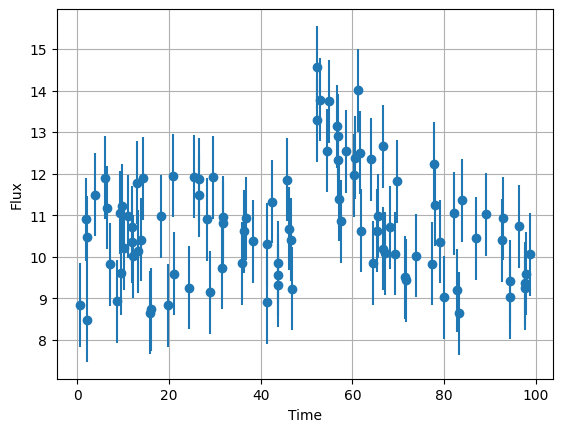

In [1]:
import numpy as np
from matplotlib import pyplot as plt

data = np.load("transient.npy")
print(data.shape)

time, flux, err = data[:,0], data[:,1], data[:,2]

plt.errorbar(time, flux, yerr=err, fmt='o')
plt.xlabel("Time")
plt.ylabel("Flux")
plt.grid()
plt.show()

## Bayesian fit of the data

To fit the data we have to compute the posterior distribution that is the product between the likelihood of the data and the prior distribution, our initial knowledge about the data. 

We can think to describe the data with a brust model like: 
$$
f(t) =
\begin{cases} 
b & \text{if } t < t_0 \\
b + A \cdot e^{-\alpha \cdot (t - t_0)} & \text{if } t \geq t_0
\end{cases}
$$

and we can think to use a prior distribution uniform in $b, A, t_0$ and linear in $\alpha$.
The logarithm of the prior is proportional to $\log(\alpha)$. 

On the other hand we can think to built a likelihood as a normal distribution between the data and the predicted data from the brust model. 
In this way the logarithm of the likelihood is simply the exponent of the gaussian: 
$$
-\frac{1}{2}\bigg(\frac{y-\hat{y}}{\sigma}\bigg)^2 = -\frac{1}{2}\chi^2
$$
where $\hat{y} = f(t)$.

## EMCEE library
To sample the posterior distribution we can use the `emcee` library that is a python implementation of the **affine invariant ensemble sampler** for Markov chain Monte Carlo (MCMC).

Remeber that an affine transformation is a linear transformation followed by a translation.
$$
y = Ax + b
$$
The affine invariant ensemble sampler is a MCMC method that is invariant under affine transformations of the parameter space. This means that the performance of the sampler does not depend on the scaling or rotation of the parameter space, making it more robust and efficient for sampling complex distributions.

In [2]:
def brust_model(t, theta):
    b, A, t0, alpha = theta
    return np.where(t < t0, b, b + A * np.exp(-alpha * (t - t0)))

b_min, b_max = 0, 50
A_min, A_max = 0, 50
t0_min, t0_max = 0, 100
alpha_min, alpha_max = np.exp(-5), np.exp(5)

def log_likelihood(theta, x, y, y_err, model=brust_model):
    y_fit = model(x, theta)
    chi2 = np.sum(((y - y_fit) / y_err) ** 2)
    return  -0.5 * chi2

def log_prior(theta):
    b, A, t0, alpha = theta
    if b_min < b < b_max and A_min < A < A_max and t0_min < t0 < t0_max and alpha_min < alpha < alpha_max:
        return -np.log(alpha) 
    return -np.inf # invalid region, if I am out of the true region , prob = 0 

def log_posterior(theta, x, y, y_err, model=brust_model):
    return log_likelihood(theta, x, y, y_err, model) + log_prior(theta)

In [3]:
b_0, A_0, t0_0, alpha_0 = np.median(flux[:50]), np.max(flux)-np.median(flux[:50]), time[np.argmax(flux)], 1
initial= np.array([b_0, A_0, t0_0, alpha_0])
print(initial)

ndim = len(initial)
nwalkers = 20 # the emcee algorithm requires multiple walkers instead of the Metropolis-Hastings single walker
# we use multiple walkers to explore the parameter space more efficiently
steps = 1e4 # number of steps for each walker

initial_guess = initial + 1e-1 * np.random.randn(nwalkers, ndim) # matrix for initial positions of the walkers
# each walker starts from a position close to the initial guess with some random noise
print(initial_guess)

[10.43656214  4.12137189 52.18483218  1.        ]
[[10.55688575  4.15422919 52.33365388  1.04703124]
 [10.52766865  4.15760872 52.2078791   1.0713168 ]
 [10.5962757   4.26492004 52.29232288  0.89616299]
 [10.39062081  4.06659572 52.30867454  0.9343527 ]
 [10.45309594  4.02482049 52.07909609  1.02242274]
 [10.50648081  4.10812893 52.20951036  1.0285013 ]
 [10.32192007  4.17522919 52.05829658  0.82411705]
 [10.38915887  4.087406   52.17007803  1.10305705]
 [10.30604078  4.18047455 52.03064537  1.13169404]
 [10.48562763  4.02437075 52.15438118  0.92645094]
 [10.3058575   4.05523253 52.18282319  0.97635637]
 [10.57039427  4.32981765 52.15353268  1.04488707]
 [10.32992197  3.94758622 52.34953611  1.01800414]
 [10.41584984  4.14205816 52.13689987  1.11638286]
 [10.3974908   4.02373442 52.20407403  0.96290049]
 [10.54493137  4.12239215 52.08990014  1.07037477]
 [10.18632995  4.140644   52.24187027  1.04999633]
 [10.48074333  4.01220391 52.24265776  1.09752914]
 [10.31568078  4.12092862 52.310

We use `emcee.EnsembleSampler` for generate lot of samples that after the first (burn in) points follow the posterior distribution. 
These samples are generated with multiple walker, and each of them has his own chain.
This is useful to explore the parameter space more efficiently.

100%|██████████| 10000/10000 [00:11<00:00, 859.93it/s]


(10000, 20, 4)


Text(0.5, 0, 'step number')

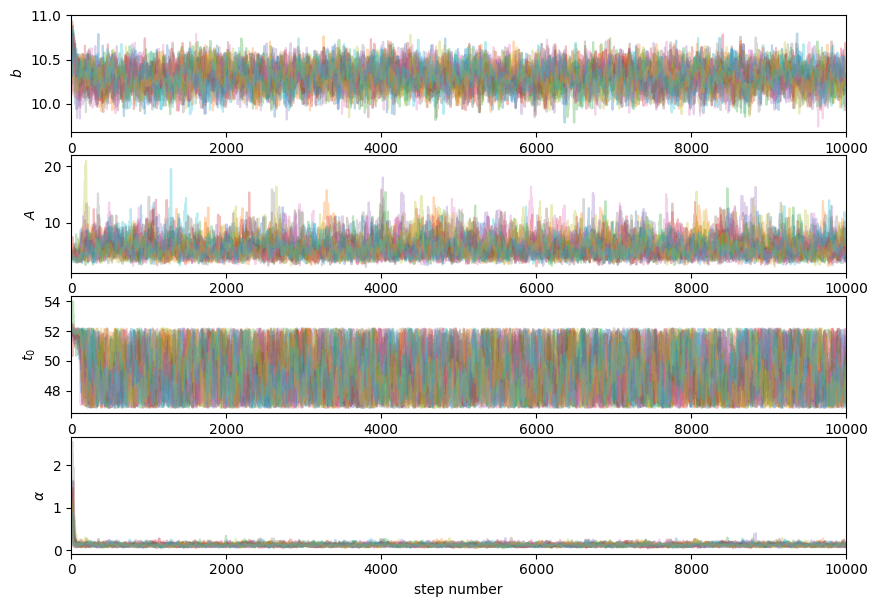

In [4]:
import emcee

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[time, flux, err])
sampler.run_mcmc(initial_guess, int(steps), progress=True)

samples = sampler.get_chain()
print(samples.shape)
labels = [r'$b$', r'$A$', r'$t_0$', r'$\alpha$']

fig, axes = plt.subplots(4, figsize=(10, 7))
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])

axes[-1].set_xlabel("step number")

### Autocorrelation time

In general the samples generated with MCMC are not indipendent, because each sample is generated from the previous one. 
We can measure the number of steps necessary to generate indipendent samples, this is the **autocorrelation time**.

We can define the burn in as three times the maximum autocorrelation time value.

In [12]:
tau = sampler.get_autocorr_time()
print(tau)

burn_in = int(3 * np.max(tau))

[59.0438296  72.38650536 78.17729952 44.06257914]


In [13]:
flat_samples = sampler.get_chain(discard=burn_in, thin=int(max(tau)), flat=True)
# thin=int(max(tau)) -> This "thins" the chain by keeping only every max(tau)-th sample 
# Thinning ensures that the samples are approximately independent, reducing redundancy in the data.
print(flat_samples.shape)

(2500, 4)


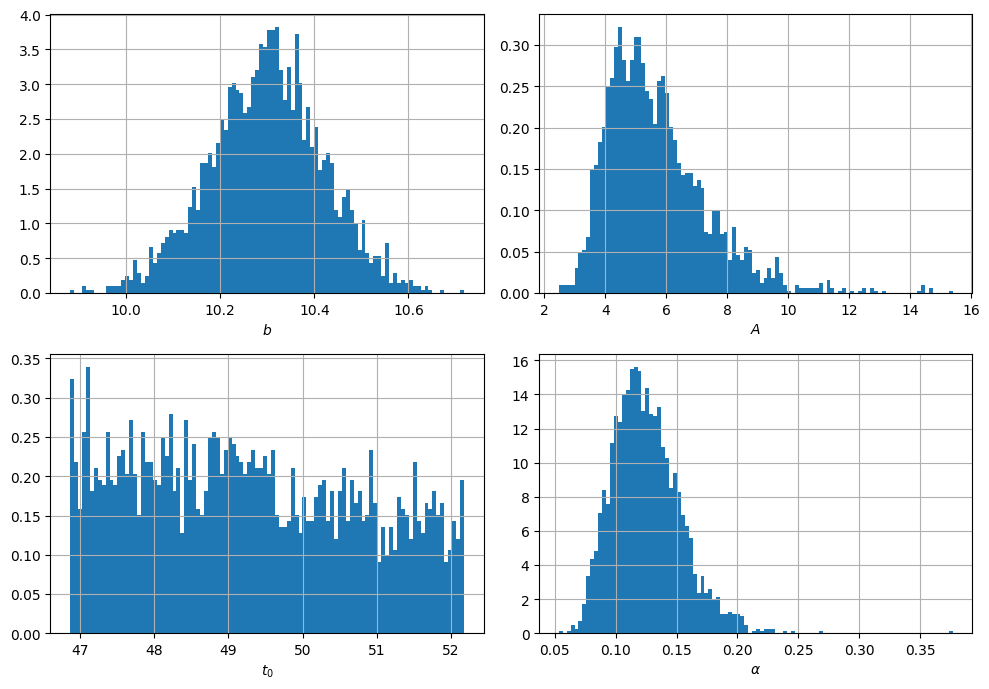

In [17]:
#plot the histograms of the parameters
fig, axes = plt.subplots(2, 2, figsize=(10, 7))
axes = axes.flatten()
for i in range(ndim):
    ax = axes[i]
    ax.hist(flat_samples[:, i], bins=100, density=True)
    ax.set_xlabel(labels[i])
    ax.grid()
plt.tight_layout()
plt.show()

The distribution doesn't have simmetric shapes, so the best estimator we can use are the median with interquantile range.

Text(0.5, 0, 'step number')

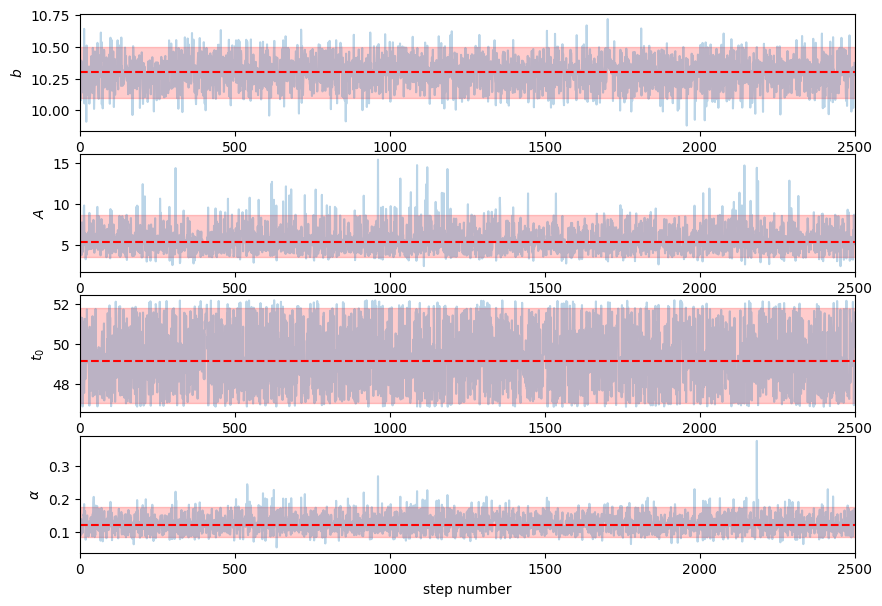

In [15]:
fig, axes = plt.subplots(4, figsize=(10, 7))
for i in range(ndim):
    ax = axes[i]
    ax.plot(flat_samples[:, i], alpha=0.3)
    ax.set_xlim(0, len(flat_samples))
    ax.set_ylabel(labels[i])
    lower, median, upper = np.percentile(flat_samples[:, i], [5, 50, 95])
    ax.axhline(median, linestyle="--", color='red', )
    ax.fill_between(ax.get_xlim(), lower, upper, color='red', alpha=0.2) # 90% interquantile range

axes[-1].set_xlabel("step number")

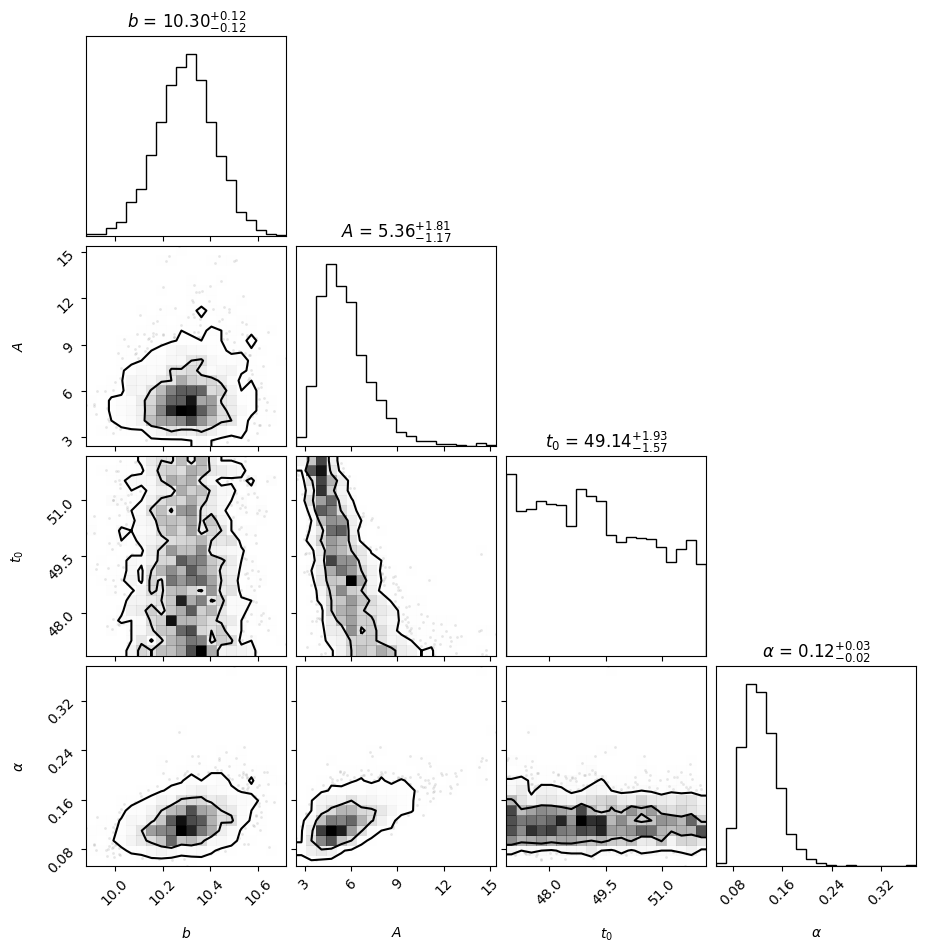

In [16]:
import corner

fig = corner.corner(flat_samples, labels=labels, levels=[0.68, 0.95], show_titles=True)

We can now observe the result of the fit randomly sampling 100 different parameter sets

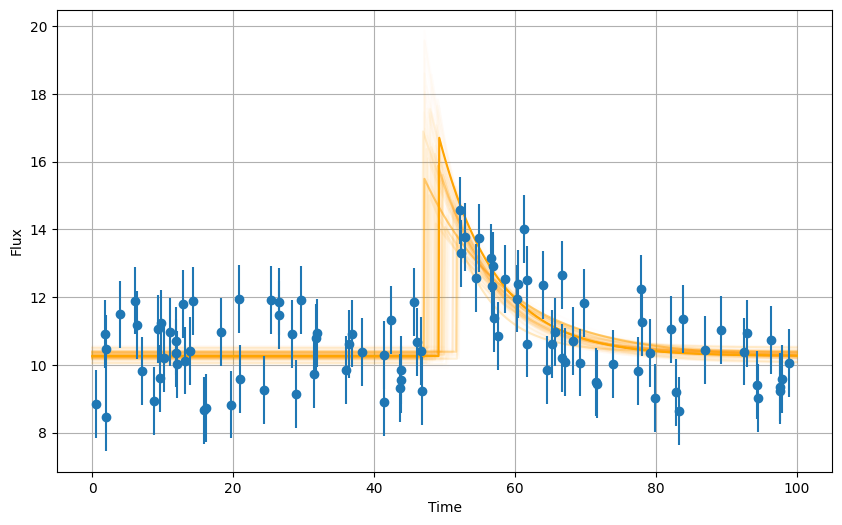

In [20]:
sample_choosen = flat_samples[np.random.choice(len(flat_samples), size=100)]
time_values = np.linspace(0, 100, 1000)

plt.figure(figsize=(10, 6))
for i, sample in enumerate(sample_choosen):
    plt.plot(time_values, brust_model(time_values, sample), color='orange', alpha=1/(i+1))
plt.errorbar(time, flux, yerr=err, fmt='o', label='data')
plt.xlabel("Time")
plt.ylabel("Flux")
plt.grid()
plt.show()
